# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:


Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
!pip install sqlalchemy
#!pip install psycopg2 #### на рабочем компе не устанавливается, хотя в Spyder спокойно работает. На домашнем ноуте - все ок

In [4]:
!pip install phik

     |████████████████████████████████| 677 kB 1.6 MB/s eta 0:00:01


In [5]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from phik import phik_matrix
from scipy import stats

In [ ]:
import os
from dotenv import load_dotenv

In [ ]:
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    DB_USER,
    DB_PASSWORD,
    DB_HOST,
    DB_PORT,
    DB_NAME,

)

In [8]:
engine = create_engine(connection_string)

In [9]:
tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [10]:
query = '''
SELECT 
	p.user_id, p.device_type_canonical,	p.order_id, p.created_dt_msk::date order_dt, p.created_ts_msk order_ts, p.currency_code, p.revenue, p.tickets_count,
	EXTRACT (DAY FROM p.created_dt_msk - lag(p.created_dt_msk) over(PARTITION BY p.user_id ORDER BY p.created_dt_msk)) days_since_prev,
	p.event_id, e.event_name_code event_name, p.service_name, e.event_type_main, r.region_name, c.city_name
FROM afisha.purchases p JOIN afisha.events e using(event_id) JOIN afisha.city c using(city_id) JOIN afisha.regions r using(region_id)
WHERE device_type_canonical IN ('mobile','desktop') 
	AND event_type_main <> 'фильм'
ORDER BY user_id;
'''

In [11]:
df = pd.read_sql_query(query, con=engine)

In [12]:
df.info()
print(df)
tenge.info()
print(tenge)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  object        
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  event_type_main        290611 non-null  obje

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Информация о датафреймах приведена выше. 290611 строк в основной выгрузке. 357 - в выгрузке с сайта ЦБ. В целом данные выгружены верно. Типы определены корректно, кроме даты order_dt и data в первом и втором датафрейме. Проверки пропусков осуществлялись на этапе разработки запроса. 

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Конвертируем типы данных в полях с датами и объединим два датафрема. После объединения расчитаем значения нового поля - `revenue_rub`.

In [13]:
df['order_dt'] = pd.to_datetime(df['order_dt'], errors='coerce', format='%Y-%m-%d')
tenge['data'] = pd.to_datetime(tenge['data'], errors='coerce', format='%Y-%m-%d')
# print(df.info())
# print(tenge.info())
# print(df)
# print(tenge)

In [14]:
main = pd.merge(df, tenge, left_on='order_dt', right_on='data', how='left') #left - чтобы не терять строки
main.loc[main['currency_code'] == 'kzt', 'revenue_rub'] = main['revenue'] / main['nominal'] * main['curs']
main.loc[main['currency_code'] != 'kzt', 'revenue_rub'] = main['revenue']

In [15]:
main[['currency_code','curs','revenue','revenue_rub']].loc[main['currency_code'] == 'kzt'].head(10)

,currency_code,curs,revenue,revenue_rub
70,kzt,19.0125,518.10,98.503762
89,kzt,18.9330,347.18,65.731589
96,kzt,18.5991,328.77,61.148261
277,kzt,19.8928,22021.55,4380.702898
460,kzt,19.9833,7397.66,1478.296591
461,kzt,19.9833,7397.66,1478.296591
462,kzt,19.9833,5548.24,1108.721444
463,kzt,19.9833,3698.83,739.148295
464,kzt,19.9833,7397.66,1478.296591
515,kzt,18.4217,361.08,66.517074


In [16]:
main[['currency_code','curs','revenue','revenue_rub']].loc[main['currency_code'] == 'rub'].head(10)

,currency_code,curs,revenue,revenue_rub
0,rub,18.6972,1521.94,1521.94
1,rub,18.3419,289.45,289.45
2,rub,19.6475,1258.57,1258.57
3,rub,18.5010,8.49,8.49
4,rub,19.6648,1390.41,1390.41
5,rub,20.0531,902.74,902.74
6,rub,18.7730,917.83,917.83
7,rub,19.3741,47.78,47.78
8,rub,19.7185,74.84,74.84
9,rub,18.0419,1421.91,1421.91


In [17]:
main.isnull().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
data                         0
nominal                      0
curs                         0
cdx                          0
revenue_rub                  0
dtype: int64

Пропуски - только в поле days-since_prev. Конертация курсов прошла успешно.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Пропуски - только в `days_since_prev` - установлено ранее. Типы преобразованы

In [18]:
main = main.drop(['curs','cdx','data','currency_code','revenue','nominal'], axis=1)
main.head(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк,1390.41


In [19]:
print(pd.unique(main['event_type_main']))
print(pd.unique(main['service_name']))
# print(pd.unique(main['tickets_count']))
# print(pd.unique(main['region_name']))
# print(main['city_name'].value_counts().sum())

['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']


Явных существенных ошибок в данных не зафиксировано. В поле event_type_main значение "другое" может использоваться в качестве заглушки. Уникальность городов, регионов, операторов проверялась на этапе разработки запроса. На случай, если в этих полях все жеимеются неявные дубликаты, приведем их в upper case и удалим явные дубликаты

In [20]:
main['service_name_upper'] = main['service_name'].str.upper()
main['region_name_upper'] = main['region_name'].str.upper()
main['city_name_upper'] = main['city_name'].str.upper()

In [21]:
d_subset=['user_id','device_type_canonical','order_id','tickets_count','event_id','event_name',
          'service_name_upper','region_name_upper','city_name_upper']
main['is_duplicated'] = main.duplicated(subset=d_subset, keep='first')
print('Дублирующиеся строки:')
print(main['is_duplicated'].value_counts())
main[main['is_duplicated']]

Дублирующиеся строки:
False    290611
Name: is_duplicated, dtype: int64


,user_id,device_type_canonical,order_id,order_dt,order_ts,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,revenue_rub,service_name_upper,region_name_upper,city_name_upper,is_duplicated


Дублированных строк нет. Удалим поля с upper_case

In [22]:
main = main.drop(['service_name_upper','region_name_upper','city_name_upper','is_duplicated'], axis=1)
main.head(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк,1390.41


Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.

Важные показатели в рамках поставленной задачи — это выручка с заказа (revenue_rub) и количество билетов в заказе (tickets_count), поэтому в первую очередь проверьте данные в этих столбцах.

Если обнаружите выбросы в поле revenue_rub, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

Сводные таблицы cо средним, минимальным, максимальным значениями (для экономии места и читаемости вывод некоторых представлений сводных таблиц закомментирован):

In [23]:
main['ticket_price'] = main['revenue_rub']/main['tickets_count']
main_pivot_event = main.pivot_table(values='revenue_rub', index='event_type_main', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_region = main.pivot_table(values='revenue_rub', index='region_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_city = main.pivot_table(values='revenue_rub', index='city_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_operator = main.pivot_table(values='revenue_rub', index='service_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_event[['min','max','mean','count','sum','median']]
# print(main_pivot_region[['min','max','mean']])
# print(main_pivot_city[['min','max','mean']])
# print(main_pivot_operator[['min','max','mean']])

,min,max,mean,count,sum,median
,revenue_rub,revenue_rub,revenue_rub,revenue_rub,revenue_rub,revenue_rub
event_type_main,,,,,,
выставки,-6.33,3656.87,232.871844,4854,1.130360e+06,157.55
другое,-17.94,6414.34,238.235437,65867,1.569185e+07,95.04
концерты,-5.70,81174.54,807.912260,115276,9.313289e+07,666.90
спорт,-90.76,18641.92,160.156237,21911,3.509183e+06,96.13
стендап,3.97,24680.88,711.575999,13393,9.530137e+06,537.80
театр,0.00,8161.31,548.467897,67321,3.692341e+07,356.83
ёлки,26.02,4362.15,772.999211,1989,1.537495e+06,606.41


In [24]:
main_pivot_event_t = main.pivot_table(values='tickets_count', index='event_type_main', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_region_t = main.pivot_table(values='tickets_count', index='region_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_city_t = main.pivot_table(values='tickets_count', index='city_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_operator_t = main.pivot_table(values='tickets_count', index='service_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_event_t[['min','max','mean','count','sum','median']]
# print(main_pivot_region[['min','max','mean']])
# print(main_pivot_city[['min','max','mean']])
# print(main_pivot_operator[['min','max','mean']])

,min,max,mean,count,sum,median
,tickets_count,tickets_count,tickets_count,tickets_count,tickets_count,tickets_count
event_type_main,,,,,,
выставки,1,6,2.556654,4854,12410,3
другое,1,57,2.769642,65867,182428,3
концерты,1,12,2.656086,115276,306183,3
спорт,1,47,3.053215,21911,66899,3
стендап,1,6,2.992309,13393,40076,3
театр,1,19,2.759674,67321,185784,3
ёлки,1,8,3.344897,1989,6653,3


In [25]:
main_pivot_event_tp = main.pivot_table(values='ticket_price', index='event_type_main', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_region_tp = main.pivot_table(values='ticket_price', index='region_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_city_tp = main.pivot_table(values='ticket_price', index='city_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_operator_tp = main.pivot_table(values='ticket_price', index='service_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_event_tp[['min','max','mean','count','sum','median']]

,min,max,mean,count,sum,median
,ticket_price,ticket_price,ticket_price,ticket_price,ticket_price,ticket_price
event_type_main,,,,,,
выставки,-1.385,1500.080000,88.737251,4854,4.307306e+05,67.003333
другое,-3.670,1603.585000,79.077758,65867,5.208615e+06,36.160000
концерты,-5.700,21757.540000,301.208430,115276,3.472210e+07,280.420000
спорт,-18.152,3728.385000,52.404560,21911,1.148236e+06,35.380000
стендап,3.465,4936.177500,239.022379,13393,3.201227e+06,199.483333
театр,0.000,2720.436667,197.248387,67321,1.327896e+07,142.340000
ёлки,24.100,858.106667,240.315850,1989,4.779882e+05,196.500000


Присутствуют выбросы - очень дорогие заказы по 81 тыс. руб. (уже позже посчитал цену билета - 21.8 тыс. руб., также можно ситать выбросом - т.е. это не влияние большого количества билетов в заказе.)

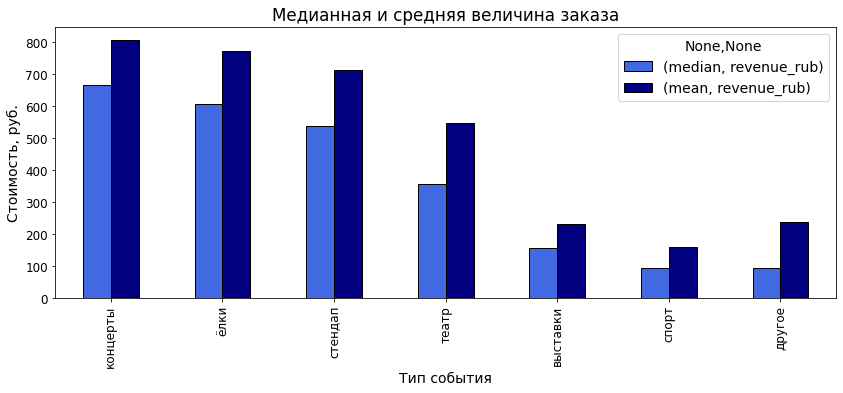

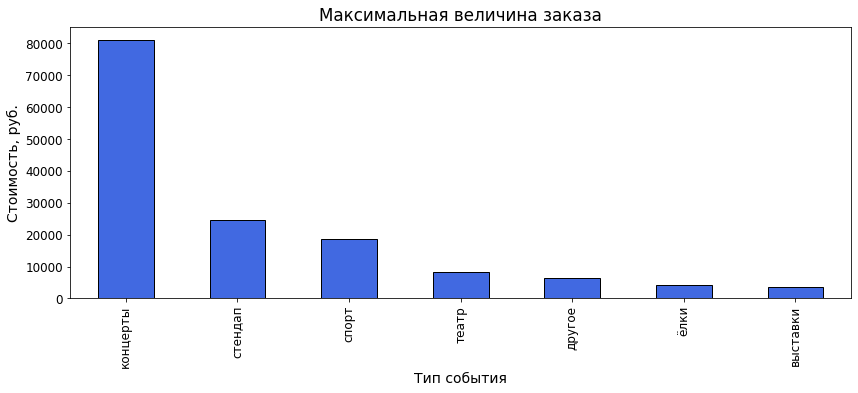

In [94]:
a = main_pivot_event[['median','mean']]
b = main_pivot_event[['max']]
a.sort_values(by=a.columns[0],ascending=False).plot(kind='bar', xlabel='Тип события', ylabel='Стоимость, руб.', legend=True
                 , rot=90, 
    title='Медианная и средняя величина заказа', 
    figsize=(14,5),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.show()
b.sort_values(by=b.columns[0],ascending=False).plot(kind='bar', xlabel='Тип события', ylabel='Стоимость, руб.', legend=False
                 , rot=90, 
    title='Максимальная величина заказа', 
    figsize=(14,5),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.show()

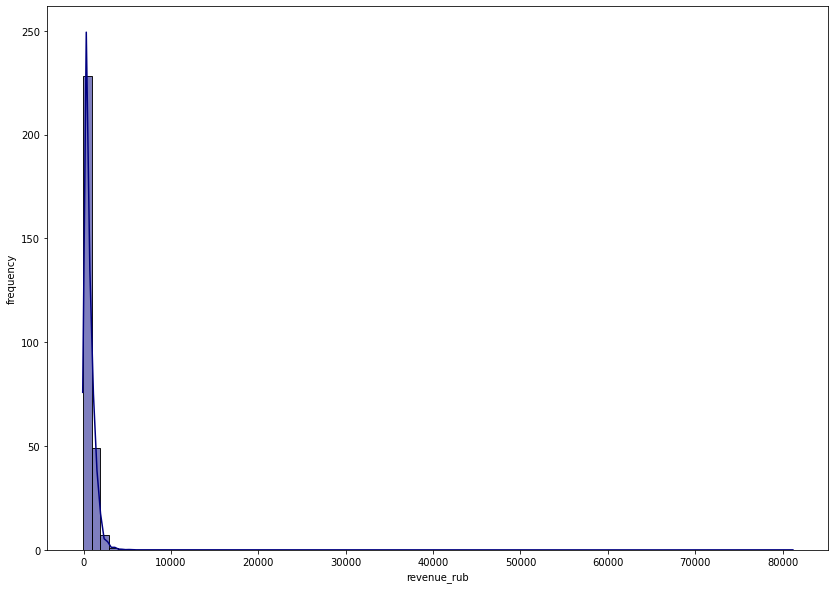

In [27]:
#Гистограммы
plt.figure(figsize=(14,10))
sns.histplot(data=main, x='revenue_rub', bins=80, kde=True, stat='frequency', color='navy')
plt.xlabel('revenue_rub')
plt.ylabel('frequency')
plt.show()

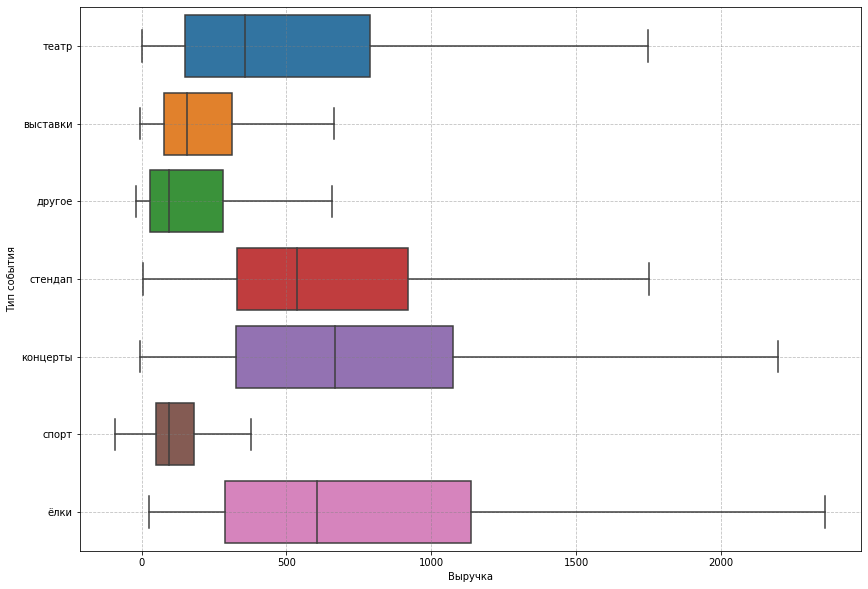

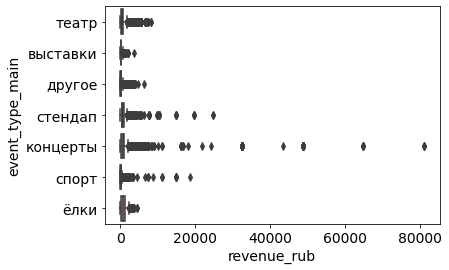

In [28]:
plt.figure(figsize=(14, 10)) 
# sns.boxplot(data=main, y='event_type_main', x='revenue_rub', showfliers=True)
sns.boxplot(data=main, y='event_type_main', x='revenue_rub', showfliers=False)
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
plt.ylabel('Тип события')
plt.xlabel('Выручка')
plt.show()
sns.boxplot(data=main, y='event_type_main', x='revenue_rub', showfliers=True)
plt.show()

Отфильтруем датафрейм по 99 квантилю по полю revenue_rub

In [29]:
threshold = main['revenue_rub'].quantile(0.99)
# Фильтруем: оставляем только строки, где value ≤ 99-му перцентилю
main_f = main[main['revenue_rub'] <= threshold]

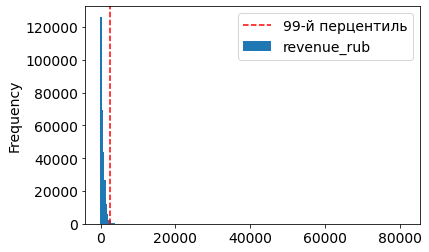

In [30]:
main['revenue_rub'].plot(kind='hist', bins=222)
plt.axvline(threshold, color='red', linestyle='--', label='99-й перцентиль')
plt.legend()

In [31]:
print('Отфильтровано строк: ',main.shape[0]-main_f.shape[0])

Отфильтровано строк:  2825


Посмотрим, как поменялась гистограмма (график по городам и регионам аналогичен, но из-за большого количества сущностей плохо читаем, плюс экономлю время):

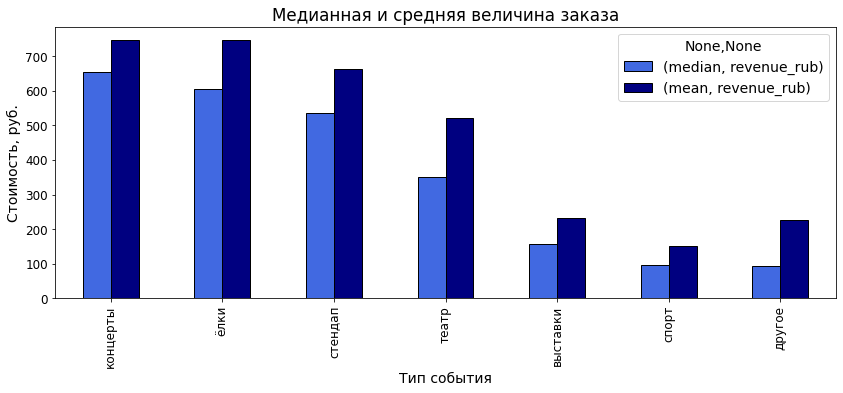

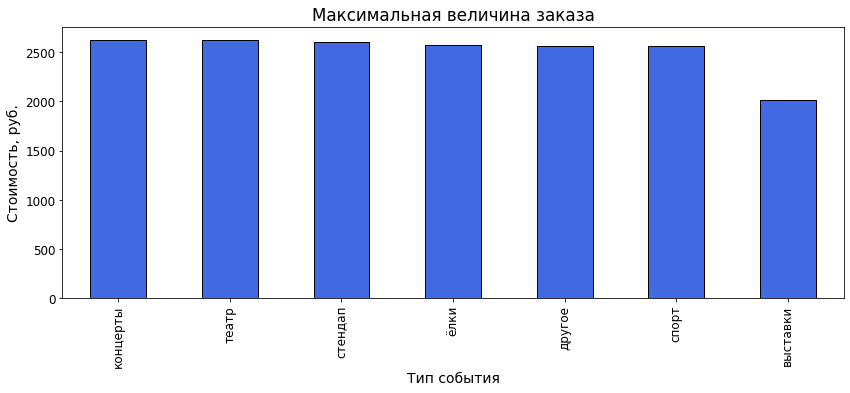

In [93]:
main_f_pivot_event = main_f.pivot_table(values='revenue_rub', index='event_type_main', aggfunc=['mean','min','max','count','sum','median'])
c = main_f_pivot_event[['median','mean']]
d = main_f_pivot_event[['max']]
c.sort_values(by=c.columns[0],ascending=False).plot(kind='bar', xlabel='Тип события', ylabel='Стоимость, руб.', legend=True
                 , rot=90, 
    title='Медианная и средняя величина заказа', 
    figsize=(14,5),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.show()
d.sort_values(by=d.columns[0],ascending=False).plot(kind='bar', xlabel='Тип события', ylabel='Стоимость, руб.', legend=False
                 , rot=90, 
    title='Максимальная величина заказа', 
    figsize=(14,5),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.show()

После фильтрации по 99 квантилю распределение данных по заказам стало более равномерным по разным типам событий.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [33]:
#backup датафрейма
df = main
# Сначала сортируем по user_id и времени заказа (order_ts)
df_sorted = df.sort_values(['user_id', 'order_ts']).reset_index(drop=True)

# Группируем по user_id и агрегируем
profile = df_sorted.groupby('user_id', sort=False).agg(
    first_order_dt=('order_dt', 'min'),          # дата первого заказа
    last_order_dt=('order_dt', 'max'),           # дата последнего заказа
    
    # Первый заказ: берём значения первой строки в группе (после сортировки)
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    
    total_orders=('order_id', 'count'),          # общее количество заказов
    avg_revenue_rub=('revenue_rub', 'mean'),     # средняя выручка в рублях
    avg_tickets_per_order=('tickets_count', 'mean'),  # среднее количество билетов
    avg_days_between_orders=('days_since_prev', 'mean')  # среднее время между заказами (NULL/NaN игнорируются
).reset_index()

# Добавляем бинарные признаки
profile['is_two'] = (profile['total_orders'] >= 2).astype(int)
profile['is_five'] = (profile['total_orders'] >= 5).astype(int)

# (опционально) приведём типы, если нужно
# profile['first_order_dt'] = pd.to_datetime(profile['first_order_dt'])
# profile['last_order_dt'] = pd.to_datetime(profile['last_order_dt'])

In [34]:
profile.info()
profile

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21933 entries, 0 to 21932
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21933 non-null  object        
 1   first_order_dt           21933 non-null  datetime64[ns]
 2   last_order_dt            21933 non-null  datetime64[ns]
 3   first_device             21933 non-null  object        
 4   first_region             21933 non-null  object        
 5   first_service            21933 non-null  object        
 6   first_event_type         21933 non-null  object        
 7   total_orders             21933 non-null  int64         
 8   avg_revenue_rub          21933 non-null  float64       
 9   avg_tickets_per_order    21933 non-null  float64       
 10  avg_days_between_orders  13559 non-null  float64       
 11  is_two                   21933 non-null  int64         
 12  is_five                  21933 n

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_per_order,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.000,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.000,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21928,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,Каменевский регион,Мой билет,другое,9,688.043333,2.555556,13.375,1,1
21929,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,Каменевский регион,Билеты без проблем,стендап,2,850.995000,2.500000,74.000,1,0
21930,fffcd3dde79eb2c,2024-06-20,2024-10-30,desktop,Каменевский регион,Билеты без проблем,концерты,33,557.908485,2.787879,4.125,1,1
21931,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,Широковская область,Билеты без проблем,стендап,1,661.530000,2.000000,NaN,0,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [35]:
user_count = profile['user_id'].value_counts().sum()
avg_order_rev = (profile['total_orders']*profile['avg_revenue_rub']).sum()/(profile['total_orders'].sum())
is_two_share = profile['is_two'].sum()/profile.shape[0]
is_five_share = profile['is_five'].sum()/profile.shape[0]
print('Общее число пользователей в выборке: ', user_count)
print('Средняя выручка с одного заказа: ', round(avg_order_rev,2), 'руб.')
print('Доля пользователей, совершивших 2 и более заказа: ', round(is_two_share,2))
print('Доля пользователей, совершивших 5 и более заказов: ', round(is_five_share,2))

Общее число пользователей в выборке:  21933
Средняя выручка с одного заказа:  555.57 руб.
Доля пользователей, совершивших 2 и более заказа:  0.62
Доля пользователей, совершивших 5 и более заказов:  0.29


In [36]:
# Также изучите статистические показатели:
# по общему числу заказов; total_orders
# по среднему числу билетов в заказе; avg_tickets_per_order
# по среднему количеству дней между покупками. avg_days_between_orders

In [37]:
print('total_orders:')
print('Мин:',     profile['total_orders'].min())
print('Макс:',    profile['total_orders'].max())
print('Среднее:', profile['total_orders'].mean())
print('Медиана:', profile['total_orders'].median())
print()
print('avg_tickets_per_order:')
print('Мин:',     profile['avg_tickets_per_order'].min())
print('Макс:',    profile['avg_tickets_per_order'].max())
print('Среднее:', profile['avg_tickets_per_order'].mean())
print('Медиана:', profile['avg_tickets_per_order'].median())
print()
print('avg_days_between_orders:')
print('Мин:',     profile['avg_days_between_orders'].min())
print('Макс:',    profile['avg_days_between_orders'].max())
print('Среднее:', profile['avg_days_between_orders'].mean())
print('Медиана:', profile['avg_days_between_orders'].median())

total_orders:
Мин: 1
Макс: 10251
Среднее: 13.249943008252405
Медиана: 2.0

avg_tickets_per_order:
Мин: 1.0
Макс: 12.0
Среднее: 2.755987073396934
Медиана: 2.7641509433962264

avg_days_between_orders:
Мин: 0.0
Макс: 148.0
Среднее: 15.808536543389545
Медиана: 8.0


In [38]:
profile_sorted = profile.sort_values(['total_orders'], ascending = False)#.reset_index(drop=True)
profile_sorted

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_per_order,avg_days_between_orders,is_two,is_five
985,0beb8fc0c0a9ce1,2024-06-01,2024-10-31,mobile,Североярская область,Билеты в руки,концерты,10251,523.376768,2.873964,0.014829,1,1
2061,18e9aead0a393e7,2024-06-01,2024-10-31,mobile,Каменевский регион,Облачко,концерты,4368,508.101194,2.794643,0.034807,1,1
11114,8187dac4be757a0,2024-06-01,2024-10-31,mobile,Берёзовская область,Билеты в руки,концерты,4053,571.896656,2.756970,0.037512,1,1
5432,3ee7dc2e115847f,2024-06-01,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,3826,570.638953,2.776529,0.039739,1,1
10849,7eb4fc207ecc10f,2024-06-01,2024-10-31,mobile,Каменевский регион,Билеты без проблем,театр,3749,570.740409,2.972259,0.040555,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10623,7c0f1cdb436ce17,2024-10-31,2024-10-31,mobile,Каменевский регион,Радио ticket,другое,1,34.200000,2.000000,NaN,0,0
10626,7c158eb0fb1a02c,2024-07-30,2024-07-30,mobile,Травяная область,Лови билет!,другое,1,155.240000,2.000000,NaN,0,0
10627,7c1908cb4b166c1,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,1,80.620000,1.000000,NaN,0,0
10628,7c1cf2fdeea43b2,2024-07-30,2024-07-30,mobile,Североярская область,Лови билет!,другое,1,31.580000,3.000000,NaN,0,0


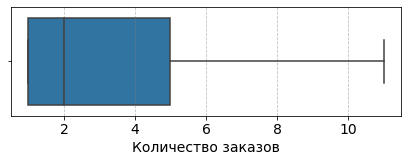

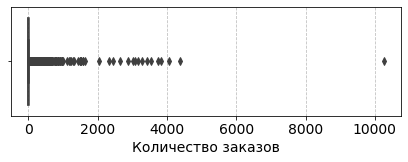

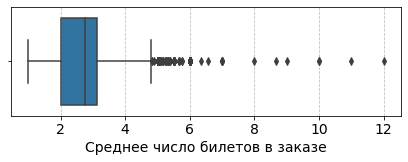

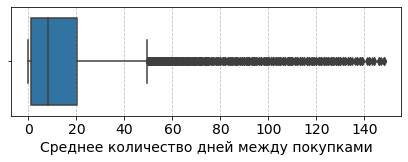

In [39]:
plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='total_orders', showfliers=False)
plt.xlabel('Количество заказов')
plt.show()
plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='total_orders', showfliers=True)
plt.xlabel('Количество заказов')
plt.show()

plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='avg_tickets_per_order', showfliers=True)
plt.xlabel('Среднее число билетов в заказе')
plt.show()

plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='avg_days_between_orders', showfliers=True)
plt.xlabel('Среднее количество дней между покупками')
plt.show()

Боксплоты со включенной опцией отображения выбросов (showfliers=True) показывают наличие выбросов по всем исследумеым полям. Однако, представляется, что выбросы в полях "среднее число билетов в заказе" и "среднее количество дней" можно оставить, т.к. они, вероятно, не являются аномалией (либо являются, но не во всех случаях): кто-то может покупать 5-12 билетов на компанию из нескольких человек, посещать мероприятия реже 50 дней.  
Обращает на себя внимание наличие пользователей с большим количеством заказов. Обычное количество заказов - до 5. Иногда - 11. Тем не менее, существуют пользователи с заказами в несколько тысяч (до 10) билетов. Вероятно, это корпоративные покупатели, агентства и т.п.  Скорее всего, они не нужны в исследовании и их можно исключить. Последовательно отфильтруем датафрейм по 99 и 95 процентилю. После фильтрации посмотрим, как изменятся боксплоты.

In [40]:
threshold99 = profile['total_orders'].quantile(0.99)
threshold95 = profile['total_orders'].quantile(0.95)

In [41]:
profile99 = profile[profile['total_orders'] <= threshold99]
profile95 = profile[profile['total_orders'] <= threshold95]

In [42]:
print(f'Удалено строк, 99% {profile.shape[0]-profile99.shape[0]}. Осталось {profile99.shape[0]} строк.')
print(f'Удалено строк, 95% {profile.shape[0]-profile95.shape[0]}. Осталось {profile95.shape[0]} строк.')

Удалено строк, 99% 219. Осталось 21714 строк.
Удалено строк, 95% 1069. Осталось 20864 строк.


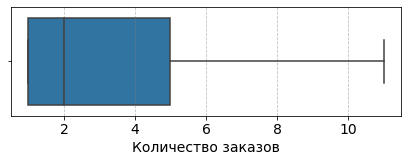

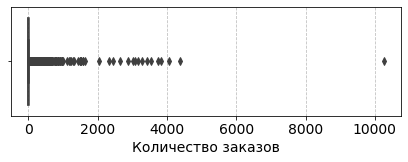

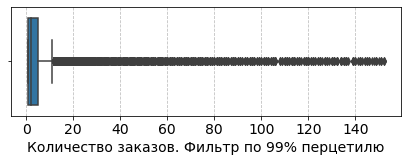

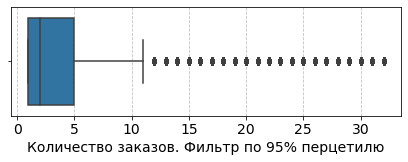

In [43]:
plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='total_orders', showfliers=False)
plt.xlabel('Количество заказов')
plt.show()
plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='total_orders', showfliers=True)
plt.xlabel('Количество заказов')
plt.show()

plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile99, x='total_orders', showfliers=True)
plt.xlabel('Количество заказов. Фильтр по 99% перцетилю')
plt.show()

plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile95, x='total_orders', showfliers=True)
plt.xlabel('Количество заказов. Фильтр по 95% перцетилю')
plt.show()

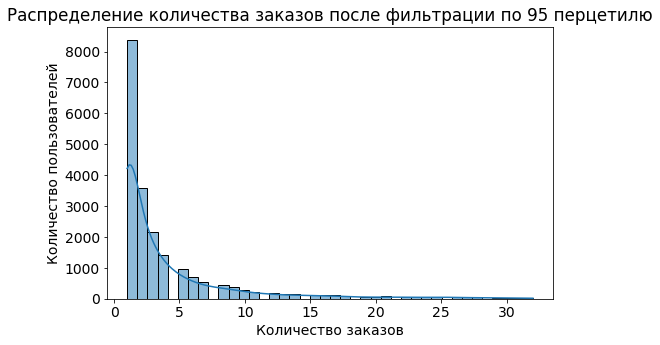

In [44]:
#гистограмма95
plt.figure(figsize=(8,5))
sns.histplot(data=profile95, x='total_orders', stat='count', bins=40, kde=True)
plt.fontsize=14
plt.title('Распределение количества заказов после фильтрации по 95 перцетилю')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

После фильтрации выбросы по количеству заказов не пропадают полностью, но их количество существенно сокращается, и, как видно из гистограммы выше, в целом таких пользователей немного. Можно оставаить фильтрацию по 95% перцентилю. Доступных данных достаточно для анализа.

In [45]:
df = profile95 #сохраняем финальный датафрейм для анализа
df.head(5)

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_per_order,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


In [92]:
print('Обновленные данные после фильтрации по 95 процентилю:')
print()
user_count = profile95['user_id'].value_counts().sum()
avg_order_rev = (profile95['total_orders']*profile95['avg_revenue_rub']).sum()/(profile95['total_orders'].sum())
is_two_share = profile95['is_two'].sum()/profile95.shape[0]
is_five_share = profile95['is_five'].sum()/profile95.shape[0]
print('Общее число пользователей в выборке: ', user_count)
print('Средняя выручка с одного заказа: ', round(avg_order_rev,2), 'руб.')
print('Доля пользователей, совершивших 2 и более заказа: ', round(is_two_share,2))
print('Доля пользователей, совершивших 5 и более заказов: ', round(is_five_share,2))
print('total_orders:')
print('Мин:',     profile95['total_orders'].min())
print('Макс:',    profile95['total_orders'].max())
print('Среднее:', profile95['total_orders'].mean())
print('Медиана:', profile95['total_orders'].median())
print()
print('avg_tickets_per_order:')
print('Мин:',     profile95['avg_tickets_per_order'].min())
print('Макс:',    profile95['avg_tickets_per_order'].max())
print('Среднее:', profile95['avg_tickets_per_order'].mean())
print('Медиана:', profile95['avg_tickets_per_order'].median())
print()
print('avg_days_between_orders:')
print('Мин:',     profile95['avg_days_between_orders'].min())
print('Макс:',    profile95['avg_days_between_orders'].max())
print('Среднее:', profile95['avg_days_between_orders'].mean())
print('Медиана:', profile95['avg_days_between_orders'].median())

Обновленные данные после фильтрации по 95 процентилю:

Общее число пользователей в выборке:  20864
Средняя выручка с одного заказа:  581.11 руб.
Доля пользователей, совершивших 2 и более заказа:  0.6
Доля пользователей, совершивших 5 и более заказов:  0.26
total_orders:
Мин: 1
Макс: 32
Среднее: 4.108080904907975
Медиана: 2.0

avg_tickets_per_order:
Мин: 1.0
Макс: 12.0
Среднее: 2.756519755964938
Медиана: 2.7777777777777777

avg_days_between_orders:
Мин: 0.0
Макс: 148.0
Среднее: 16.98027555988488
Медиана: 9.414285714285715


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


Рассчитаем сводные таблицы по группам пользователей. Учитывая задания из следующей задачи сразу посчитаем долю пользователей, совершивших два и более заказов

In [47]:
pt_fe = pd.pivot_table(data=df, index='first_event_type', values=['total_orders'], columns='is_two', aggfunc=['count'] )
df_fe = pd.DataFrame(pt_fe)
df_fe[('count', 'total_orders', 'total')] = df_fe[('count', 'total_orders', 0)]+df_fe[('count', 'total_orders', 1)]
df_fe[('count', 'total_orders', 'share2')] = df_fe[('count', 'total_orders', 1)]/(df_fe[('count', 'total_orders', 0)]+df_fe[('count', 'total_orders', 1)])
df_fe[('count', 'total_orders', 'share_tot')] = (df_fe[('count', 'total_orders', 0)]+df_fe[('count', 'total_orders', 1)])/(df_fe[('count', 'total_orders', 'total')].sum())


In [48]:
pt_fd = pd.pivot_table(data=df, index='first_device', values=['total_orders'], columns='is_two', aggfunc=['count'] )
df_fd = pd.DataFrame(pt_fd)
df_fd[('count', 'total_orders', 'total')] = df_fd[('count', 'total_orders', 0)]+df_fd[('count', 'total_orders', 1)]
df_fd[('count', 'total_orders', 'share2')] = df_fd[('count', 'total_orders', 1)]/(df_fd[('count', 'total_orders', 0)]+df_fd[('count', 'total_orders', 1)])
df_fd[('count', 'total_orders', 'share_tot')] = (df_fd[('count', 'total_orders', 0)]+df_fd[('count', 'total_orders', 1)])/(df_fd[('count', 'total_orders', 'total')].sum())


In [49]:
pt_fr = pd.pivot_table(data=df, index='first_region', values=['total_orders'], columns='is_two', aggfunc=['count'] )
df_fr = pd.DataFrame(pt_fr)
df_fr[('count', 'total_orders', 'total')] = df_fr[('count', 'total_orders', 0)]+df_fr[('count', 'total_orders', 1)]
df_fr[('count', 'total_orders', 'share2')] = df_fr[('count', 'total_orders', 1)]/(df_fr[('count', 'total_orders', 0)]+df_fr[('count', 'total_orders', 1)])
df_fr[('count', 'total_orders', 'share_tot')] = (df_fr[('count', 'total_orders', 0)]+df_fr[('count', 'total_orders', 1)])/(df_fr[('count', 'total_orders', 'total')].sum())
df_fr=df_fr.sort_values(by=df_fr.columns[2], ascending=False)#.head(10)
df_fr10=df_fr.sort_values(by=df_fr.columns[2], ascending=False).head(10)

In [50]:
pt_fs = pd.pivot_table(data=df, index='first_service', values=['total_orders'], columns='is_two', aggfunc=['count'] )
df_fs = pd.DataFrame(pt_fs)
df_fs[('count', 'total_orders', 'total')] = df_fs[('count', 'total_orders', 0)]+df_fs[('count', 'total_orders', 1)]
df_fs[('count', 'total_orders', 'share2')] = df_fs[('count', 'total_orders', 1)]/(df_fs[('count', 'total_orders', 0)]+df_fs[('count', 'total_orders', 1)])
df_fs[('count', 'total_orders', 'share_tot')] = (df_fs[('count', 'total_orders', 0)]+df_fs[('count', 'total_orders', 1)])/(df_fs[('count', 'total_orders', 'total')].sum())
df_fs=df_fs.sort_values(by=df_fs.columns[2], ascending=False)#.head(10)
df_fs10=df_fs.sort_values(by=df_fs.columns[2], ascending=False).head(10)


In [51]:
df_fe #первые мероприятия

count                                
                 total_orders                                
is_two                      0     1 total    share2 share_tot
first_event_type                                             
выставки                  149   250   399  0.626566  0.019124
другое                   2189  2992  5181  0.577495  0.248322
концерты                 3648  5607  9255  0.605835  0.443587
спорт                     352   416   768  0.541667  0.036810
стендап                   436   633  1069  0.592142  0.051237
театр                    1557  2541  4098  0.620059  0.196415
ёлки                       43    51    94  0.542553  0.004505

In [52]:
df_fd #первое устройство

count                                  
             total_orders                                  
is_two                  0      1  total    share2 share_tot
first_device                                               
desktop              1349   2220   3569  0.622023   0.17106
mobile               7025  10270  17295  0.593813   0.82894

In [53]:
df_fr #первый регион

count                                    
                         total_orders                                    
is_two                              0       1   total    share2 share_tot
first_region                                                             
Каменевский регион             2678.0  4163.0  6841.0  0.608537  0.328011
Североярская область           1357.0  2242.0  3599.0  0.622951  0.172564
Широковская область             434.0   759.0  1193.0  0.636211  0.057202
Озернинский край                304.0   359.0   663.0  0.541478  0.031789
Малиновоярский округ            233.0   289.0   522.0  0.553640  0.025029
...                               ...     ...     ...       ...       ...
Верхозёрский край                 NaN     1.0     NaN       NaN       NaN
Островогорский округ              4.0     NaN     NaN       NaN       NaN
Светолесский край                 1.0     NaN     NaN       NaN       NaN
Сосноводолинская область          1.0     NaN     NaN       NaN       NaN
Яснопольский округ                1.0     NaN     NaN       NaN       NaN

[81 rows x 5 columns]

In [54]:
df_fs.head(10)#первый оператор

count                                    
                   total_orders                                    
is_two                        0       1   total    share2 share_tot
first_service                                                      
Билеты без проблем       2051.0  2934.0  4985.0  0.588566  0.238940
Мой билет                1167.0  1717.0  2884.0  0.595354  0.138235
Лови билет!              1095.0  1620.0  2715.0  0.596685  0.130135
Билеты в руки             952.0  1472.0  2424.0  0.607261  0.116187
Облачко                   841.0  1272.0  2113.0  0.601988  0.101280
Весь в билетах            480.0   768.0  1248.0  0.615385  0.059819
Лучшие билеты             458.0   672.0  1130.0  0.594690  0.054163
Прачечная                 219.0   335.0   554.0  0.604693  0.026554
Край билетов              159.0   283.0   442.0  0.640271  0.021186
Дом культуры              125.0   214.0   339.0  0.631268  0.016249

*Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.*

Количество пользователей каждого сегмента - поле `total` в сводных таблицах выше. Доля в разрезе каждого признака - поле `share_tot`

*Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?*

Пользователи распределены не линейно. По каждому сегменту есть выраженные "точки входа". Так. например, по `признаку устройства` - это `mobile`, по `типу мероприятия` - `концерты` и `"другое"`, наиболее активный `оператор` - `"Билеты без проблем"`. По `региону` - `Каменевский регион`.  

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


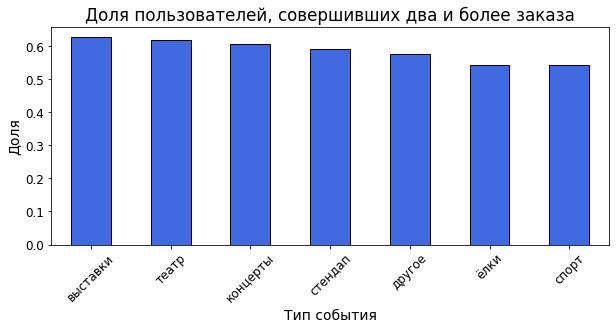

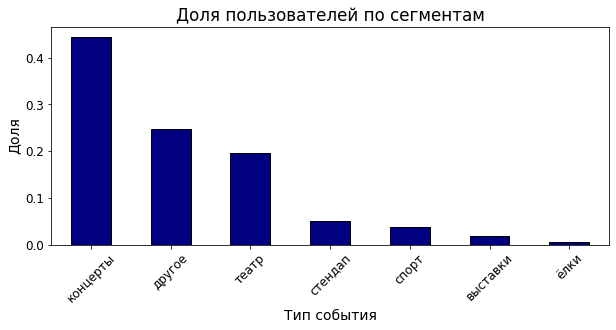

Медиана:  0.5921421889616464
Среднее:  0.5866166292015002
                        count                                
                 total_orders                                
is_two                      0     1 total    share2 share_tot
first_event_type                                             
выставки                  149   250   399  0.626566  0.019124
театр                    1557  2541  4098  0.620059  0.196415
концерты                 3648  5607  9255  0.605835  0.443587
стендап                   436   633  1069  0.592142  0.051237
другое                   2189  2992  5181  0.577495  0.248322
ёлки                       43    51    94  0.542553  0.004505
спорт                     352   416   768  0.541667  0.036810


In [55]:
df_fe[('count', 'total_orders', 'share2')].sort_values(ascending=False).plot(
    kind='bar', 
    xlabel='Тип события', 
    ylabel='Доля', 
    legend=False,
    rot=45, 
    title='Доля пользователей, совершивших два и более заказа', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue'],
    edgecolor='black'
    )
plt.show()

df_fe[('count', 'total_orders', 'share_tot')].sort_values(ascending=False).plot(
    kind='bar', 
    xlabel='Тип события', 
    ylabel='Доля', 
    legend=False,
    rot=45, 
    title='Доля пользователей по сегментам', 
    figsize=(10,4),
    fontsize = 12,
    color = ['navy'],
    edgecolor='black'
    )
plt.show()

print('Медиана: ',df_fe[('count', 'total_orders', 'share2')].median())
print('Среднее: ',df_fe[('count', 'total_orders', 'share2')].mean())
print(df_fe.sort_values(by=df_fe.columns[3], ascending=False))

По признаку первое посещенное меропритие чаще всего возвращаются пользователи, посетившие `Выставки`, `Театр`, `Концерты`. При этом доля `Выставок` в общем количестве довольно низкая, что может указывать на нестабильность результата по этому параметру.

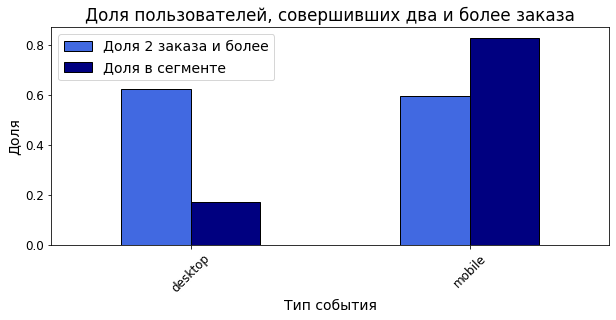

Медиана:  0.6079181082222352
Среднее:  0.6079181082222352
                    count                                  
             total_orders                                  
is_two                  0      1  total    share2 share_tot
first_device                                               
desktop              1349   2220   3569  0.622023   0.17106
mobile               7025  10270  17295  0.593813   0.82894


In [56]:
##попробуем другой формат представления графиков
df_fd[[('count', 'total_orders', 'share2'),('count', 'total_orders', 'share_tot')]].sort_values(by=df_fd.columns[3], ascending=False).plot(
    kind='bar', 
    xlabel='Тип события', 
    ylabel='Доля', 
    legend=True,
    rot=45, 
    title='Доля пользователей, совершивших два и более заказа', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.legend(labels=['Доля 2 заказа и более', 'Доля в сегменте'])  # новые подписи
plt.show()

print('Медиана: ',df_fd[('count', 'total_orders', 'share2')].median())
print('Среднее: ',df_fd[('count', 'total_orders', 'share2')].mean())
print(df_fd.sort_values(by=df_fd.columns[3], ascending=False))

Пользователи, сделавшие первый заказ через `desktop` возвращаются лишь немного чаще, но их почти в 5 раз меньше.

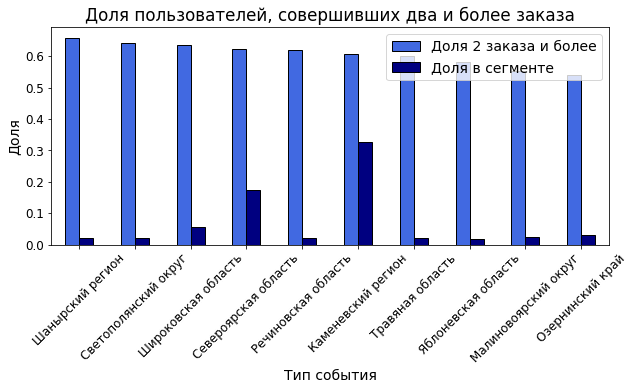

Медиана:  0.5593311758360302
Среднее:  0.5566566242268854
                            count                                    
                     total_orders                                    
is_two                          0       1   total    share2 share_tot
first_region                                                         
Шанырский регион            160.0   310.0   470.0  0.659574  0.022535
Светополянский округ        158.0   283.0   441.0  0.641723  0.021145
Широковская область         434.0   759.0  1193.0  0.636211  0.057202
Североярская область       1357.0  2242.0  3599.0  0.622951  0.172564
Речиновская область         159.0   260.0   419.0  0.620525  0.020090
Каменевский регион         2678.0  4163.0  6841.0  0.608537  0.328011
Травяная область            188.0   282.0   470.0  0.600000  0.022535
Яблоневская область         168.0   233.0   401.0  0.581047  0.019227
Малиновоярский округ        233.0   289.0   522.0  0.553640  0.025029
Озернинский край            304.

In [57]:
df_fr10[[('count', 'total_orders', 'share2'),('count', 'total_orders', 'share_tot')]].head(10).sort_values(by=df_fr.columns[3], ascending=False).plot(
    kind='bar', 
    xlabel='Тип события', 
    ylabel='Доля', 
    legend=True,
    rot=45, 
    title='Доля пользователей, совершивших два и более заказа', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.legend(labels=['Доля 2 заказа и более', 'Доля в сегменте'])  # новые подписи
plt.show()

print('Медиана: ',df_fr[('count', 'total_orders', 'share2')].median())
print('Среднее: ',df_fr[('count', 'total_orders', 'share2')].mean())
print(df_fr10.sort_values(by=df_fr10.columns[3], ascending=False))

Наиболее активные регионы представлены в таблице выше в порядке снижения доли пользователей, совершивших не менее двух заказов. Наибольшая доля вернувшихся пользователей - в Шанурском регионе, при этом в Каменевском регионе - наибольшее количество пользователей, но доля пользователей с 2 и более заказами - 6я по счету. 

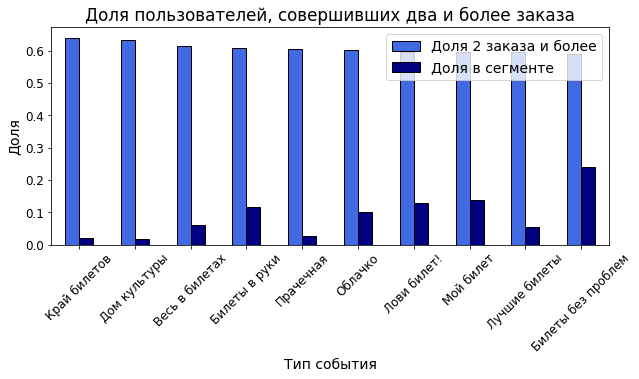

Медиана:  0.5966850828729282
Среднее:  0.5852327500393901
                          count                                    
                   total_orders                                    
is_two                        0       1   total    share2 share_tot
first_service                                                      
Край билетов              159.0   283.0   442.0  0.640271  0.021186
Дом культуры              125.0   214.0   339.0  0.631268  0.016249
Весь в билетах            480.0   768.0  1248.0  0.615385  0.059819
Билеты в руки             952.0  1472.0  2424.0  0.607261  0.116187
Прачечная                 219.0   335.0   554.0  0.604693  0.026554
Облачко                   841.0  1272.0  2113.0  0.601988  0.101280
Лови билет!              1095.0  1620.0  2715.0  0.596685  0.130135
Мой билет                1167.0  1717.0  2884.0  0.595354  0.138235
Лучшие билеты             458.0   672.0  1130.0  0.594690  0.054163
Билеты без проблем       2051.0  2934.0  4985.0  0.588566 

In [58]:
df_fs10[[('count', 'total_orders', 'share2'),('count', 'total_orders', 'share_tot')]].head(10).sort_values(by=df_fs.columns[3], ascending=False).plot(
    kind='bar', 
    xlabel='Тип события', 
    ylabel='Доля', 
    legend=True,
    rot=45, 
    title='Доля пользователей, совершивших два и более заказа', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.legend(labels=['Доля 2 заказа и более', 'Доля в сегменте'])  # новые подписи
plt.show()

print('Медиана: ',df_fs[('count', 'total_orders', 'share2')].median())
print('Среднее: ',df_fs[('count', 'total_orders', 'share2')].mean())
print(df_fs10.sort_values(by=df_fs10.columns[3], ascending=False))

У всех операторов из топ-10 по количеству пользователей доля повторных заказов выше среднего. Самые лояльные пользователи - у оператора `Край билетов`, но доля рынка последнего на фоне остальных - не велика. Результаты по таким провайдерам могут быть не стаблильными, варьироваться в зависимости от каких-либо факторов. Например, от сезона. 

Поэтому, из тех операторов, у которых доля пользователей выше 10%, самая большая доля клиентов с 2 и более заказами - у оператора `Весь в билетах`. Лидерство по абсолютному значению вернувшихся клиентов - у самого крупного  оператора `Билеты без проблем`.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [59]:
df_fe

count                                
                 total_orders                                
is_two                      0     1 total    share2 share_tot
first_event_type                                             
выставки                  149   250   399  0.626566  0.019124
другое                   2189  2992  5181  0.577495  0.248322
концерты                 3648  5607  9255  0.605835  0.443587
спорт                     352   416   768  0.541667  0.036810
стендап                   436   633  1069  0.592142  0.051237
театр                    1557  2541  4098  0.620059  0.196415
ёлки                       43    51    94  0.542553  0.004505

**Гипотеза 1** странно сформулирована. 

*Тип мероприятия влияет на вероятность возврата на Яндекс Афишу* - да, влияет. Чаще всего повторные заказы делают пользователи, посетившие выставки, театр и концерты. 

*пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты* - наоборот: повторную покупку пользователи, совершившие первый заказ на спортмеропрития, совершают реже пользователей, первый заказ которых - концерты. 

**Гипотеза 2** не поддерждается - это видно по данным одного из предыдущи графиков. У наиболее активных регионов доля хоть и высокая, но существуют регионы с большей доле повторных заказов.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


**Здесь задача некорректно сформулирована: сказано построить распределение выручки с билета, но в скобках указно `avg_revenue_rub`, хотя это средняя выручка с заказа, в котором может быть несколько билетов. В следующей задаче речь снова идет про выручку с заказа**

При расчете моды по признаку `is_two` были выявлены нулевые значения исходного поля `revenue` преимущественно у оператора Билеты без проблем. Нулевые цены будут искажать статистику при работе с показателями выручки. Исключим такие записи из датафрейма. Отрицательные выручки - возвраты - не велики и не многочисленны, можно их оставить.

In [60]:
dff = df.loc[df['avg_revenue_rub'] != 0]
# dff

In [61]:
#определим стоимость билета и запишем ее в новое поле
dff['avg_ticket_price']=dff['avg_revenue_rub']/dff['avg_tickets_per_order']

/tmp/ipykernel_63/611910349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['avg_ticket_price']=dff['avg_revenue_rub']/dff['avg_tickets_per_order']


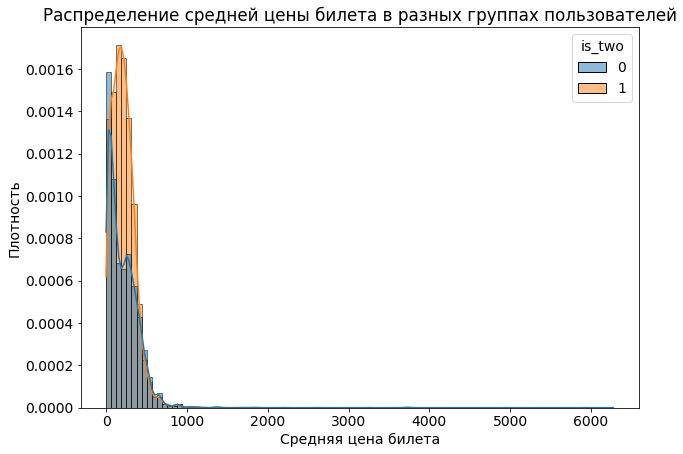

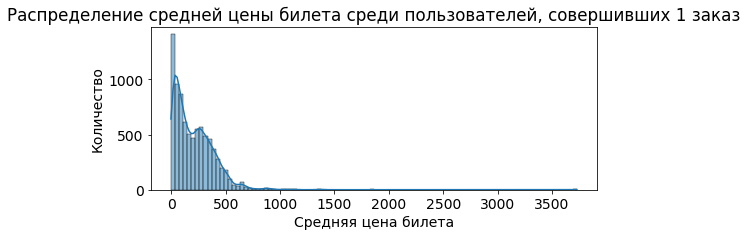

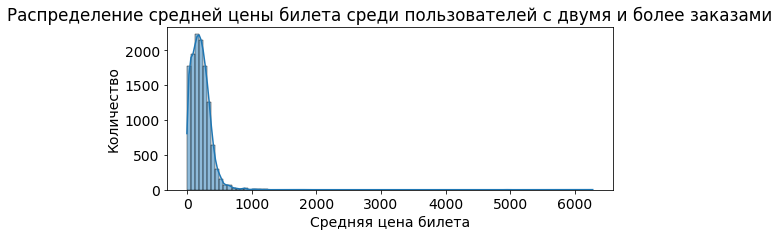

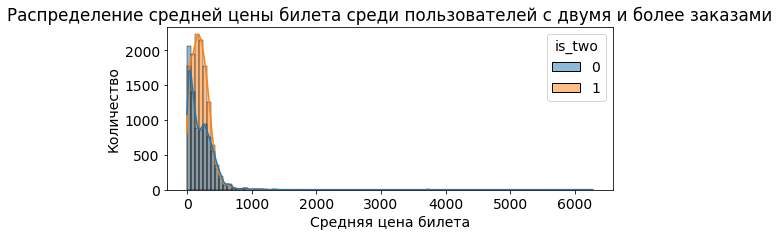

In [62]:
#гистограмма
plt.figure(figsize=(10,7))
sns.histplot(data=dff, x='avg_ticket_price', hue='is_two', bins=100, kde=True, stat='density', alpha=0.5)
plt.fontsize=14
# оранжевый график должен быть для is_two=1. 
#Почему-то задание легенды plt.legend приводит к неожиданной очередности. Поэтому сначала задаем 2+ заказов, потом 1
# так легенда сооветствует автоматически создаваемой
#plt.legend(labels=['2+ заказов','1 заказ'])  
plt.title('Распределение средней цены билета в разных группах пользователей')
plt.xlabel('Средняя цена билета')
plt.ylabel('Плотность')
plt.show()

#гистограмма
plt.figure(figsize=(8,3))
qq=dff.loc[dff['is_two']==0]
sns.histplot(data=qq, x='avg_ticket_price', bins=100, kde=True, stat='count', alpha=0.5)
plt.fontsize=14
plt.title('Распределение средней цены билета среди пользователей, совершивших 1 заказ')
plt.xlabel('Средняя цена билета')
plt.ylabel('Количество')
plt.show()

#гистограмма
plt.figure(figsize=(8,3))
ww=dff.loc[dff['is_two']==1]
sns.histplot(data=ww, x='avg_ticket_price', bins=100, kde=True, stat='count', alpha=0.5)
plt.fontsize=14
plt.title('Распределение средней цены билета среди пользователей с двумя и более заказами')
plt.xlabel('Средняя цена билета')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(8,3))
sns.histplot(data=dff, x='avg_ticket_price', hue='is_two', bins=100, kde=True, stat='count', alpha=0.5)
plt.fontsize=14
plt.title('Распределение средней цены билета среди пользователей с двумя и более заказами')
plt.xlabel('Средняя цена билета')
plt.ylabel('Количество')
plt.show()

In [63]:
# d1=dff['avg_ticket_price'].loc[dff['is_two']==0]
# d2=dff['avg_ticket_price'].loc[dff['is_two']==1]
# kde1 = stats.gaussian_kde(d1)
# kde2 = stats.gaussian_kde(d2)
# x_vals1 = np.linspace(d1.min(), d1.max(), 1000)
# y_vals1 = kde(x_vals1)
# x_vals2 = np.linspace(d2.min(), d2.max(), 1000)
# y_vals2 = kde(x_vals2)
# peak_x1 = x_vals1[np.argmax(y_vals1)]  
# peak_y1 = y_vals1.max()            
# peak_x2 = x_vals2[np.argmax(y_vals2)]  
# peak_y2 = y_vals2.max()            
# print(f"Пик KDE1: x = {peak_x1:.3f}, плотность = {peak_y1:.4f}")
# print(f"Пик KDE2: x = {peak_x2:.3f}, плотность = {peak_y2:.4f}")
# print(d1.count())
# print(d2.count())

Пользователи, совершивших два и более заказа, чаще покупают более дорогие билеты,

In [64]:
dff.groupby(['is_two'])['avg_ticket_price'].mean()

is_two
0    206.321978
1    211.014552
Name: avg_ticket_price, dtype: float64

In [65]:
aaa = dff.loc[dff['is_two'] == 1, 'avg_ticket_price']
type(aaa)
aaa.count()
aaa.mode()


0    394.45
dtype: float64

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [66]:
# dff['is_two_four'] = ((dff['total_orders'] > 1) & (dff['total_orders'] < 5)).astype(int)
# dff

dff['is_two_four'] = 0
dff.loc[dff['total_orders'] <= 1, 'is_two_four'] = 0
dff.loc[(dff['total_orders'] >= 2) & (dff['total_orders'] <= 4), 'is_two_four'] = 1
dff.loc[dff['total_orders'] >= 5, 'is_two_four'] = 2

/tmp/ipykernel_63/809939280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['is_two_four'] = 0
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

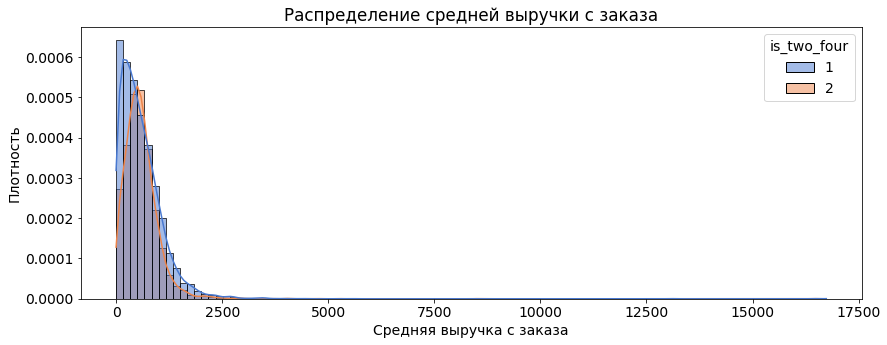

In [67]:
#гистограмма
plt.figure(figsize=(14,5))
aa=dff[dff['is_two_four'] >= 1]
sns.histplot(data=aa, x='avg_revenue_rub', hue='is_two_four', 
             palette='muted',
             bins=100, kde=True, stat='density', alpha=0.5)
plt.fontsize=14
# plt.legend(labels=['KDE, 5+ заказов','KDE, 2-4 заказа','5+ заказов','2-4 заказа','k']) ###########
plt.title('Распределение средней выручки с заказа')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Плотность')
plt.show()

# #гистограмма
# plt.figure(figsize=(10,5))
# aa=dff[dff['is_two_four'] >= 1]
# sns.histplot(data=aa, x='avg_revenue_rub', hue='is_two_four', palette='muted',
#                  bins=100, kde=True, stat='count', alpha=0.5)
# plt.fontsize=14
# plt.title('Распределение средней выручки с заказа')
# plt.xlabel('Средняя выручка с заказа')
# plt.ylabel('Количество')
# plt.show()

Мода средней выручки с пользователей, совершивших 5 и более заказов, ниже аналогичного значения для пользователей с 2-4 заказами:

In [68]:
dff.groupby('is_two_four')['avg_revenue_rub'].apply(lambda x: x.mode())

is_two_four   
0            0      31.580
1            0    1380.575
2            0     990.560
Name: avg_revenue_rub, dtype: float64

Большинство пользователей первой группы (2-4 заказа) приносят минимальную среднюю выручку. С ростом выручки число пользователей резко снижается. 
Характер распределения средней выручки для пользователей 2й группы (5+ заказов) несколько иной: сначала с ростом выручки число пользователей растет, затем после достижения максимальных значений снижается сильнее, чем у пользователей 1 группы. 
Пользователи из 2й группы чаще приносят бОльшую среднюю выручку.

In [69]:
dff.groupby(['is_two_four'])['avg_revenue_rub'].mean()

is_two_four
0    573.580686
1    582.666210
2    585.232898
Name: avg_revenue_rub, dtype: float64

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?
    
Значение средней выручки для покупателей с 5 и более заказами несущественно выше аналогичного значения для группы пользователей с 2-4 заказами - 585 руб. против 582.7 руб. 

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [70]:
dff['avg_tickets_per_order'].max()

12.0

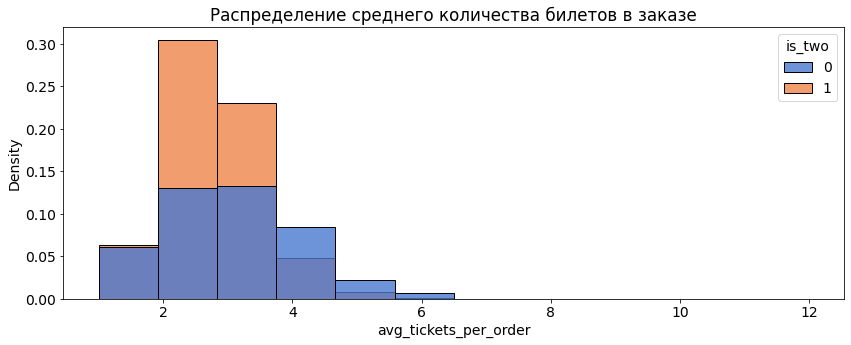

In [71]:
plt.figure(figsize=(14,5))
sns.histplot(data=dff, x='avg_tickets_per_order', hue='is_two', 
             palette='muted',
             bins=12, kde=False, stat='density', alpha=0.8)
plt.fontsize=14
# plt.legend(labels=['KDE, 5+ заказов','KDE, 2-4 заказа','5+ заказов','2-4 заказа','k']) ###########
plt.title('Распределение среднего количества билетов в заказе')
# plt.xlabel('Количество билетов')
plt.show()

Пользователи, совершившие 2+ заказа, чаще покупают 2-4 билета. Совершившие 1 заказ - также 2-4 билета, но доля таких ниже. Распределение пользователей с одним заказом болшее равномерное - чаще готовы покупать ~4 билета. Доли покупателей с заказом менее двух билетов примерно одинаковые в обеих группах пользователей.

Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе:
- от 1 до 2 билетов - группа A;
- от 2 до 3 билетов - группа B; 
- от 3 до 5 билетов - группа C;
- от 5 и более билетов - группа D.

В сводной таблице посчитаем:
 - каждого сегмента общее число пользователей
 - долю пользователей, совершивших повторные заказы.

In [72]:
dff['ticket_group'] = pd.cut(dff['avg_tickets_per_order'], bins=[1,2,3,5,100], right=False, labels=['A','B','C','D'])

/tmp/ipykernel_63/117771647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['ticket_group'] = pd.cut(dff['avg_tickets_per_order'], bins=[1,2,3,5,100], right=False, labels=['A','B','C','D'])


In [73]:
#проверка на пропуски
dff.loc[dff['ticket_group'].isna()==True]['avg_tickets_per_order']
dff['ticket_group'].value_counts().sum() #???

20728

In [74]:
pt_t = pd.pivot_table(data=dff, index='ticket_group', values=['total_orders'], columns='is_two', aggfunc=['count'])
df_t = pd.DataFrame(pt_t)
df_t[('count', 'total_orders', 'total')] = df_t[('count', 'total_orders', 0)]+df_t[('count', 'total_orders', 1)]
df_t[('count', 'total_orders', 'share2')] = df_t[('count', 'total_orders', 1)]/(df_t[('count', 'total_orders', 0)]+df_t[('count', 'total_orders', 1)])
df_t

count                      
             total_orders                      
is_two                  0     1 total    share2
ticket_group                                   
A                    1151  1221  2372  0.514755
B                    2465  6211  8676  0.715883
C                    4106  4890  8996  0.543575
D                     551   133   684  0.194444

Ответьте на вопросы:

Как распределены пользователи по сегментам — равномерно или сконцентрировано?
- Пользователи распределены неравномерно. 

Есть ли сегменты с аномально высокой или низкой долей повторных покупок?
- Немногим больше 50% пользователей в группах A (1-2 билетов) и С (3-5 билетов) совершают две и более покупки (заказа)
- ~72% пользователей, купивших 2-3 билета совершают не менее 2 заказов - можно считать показатель аномально высоким.
- Только 19% пользователей с заказами с более, чем 5 билетов, возвращаются за повторной покупкой.

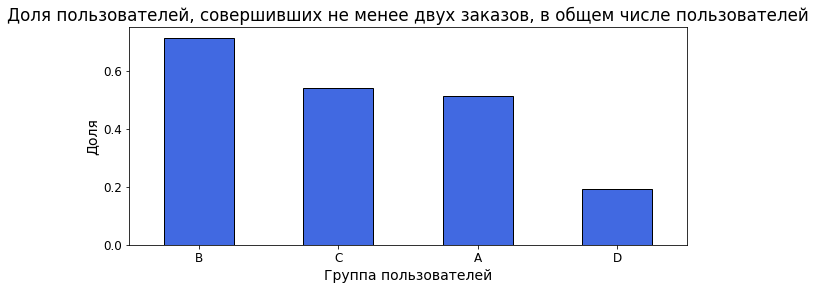

In [89]:
df_t[('count', 'total_orders', 'share2')].sort_values(ascending=False).plot(
    kind='bar', 
    xlabel='Группа пользователей', 
    ylabel='Доля', 
    legend=False,
    rot=0, 
    title='Доля пользователей, совершивших не менее двух заказов, в общем числе пользователей', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue'],
    edgecolor='black'
    )
plt.show()

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [76]:
# Определяем номер днянедели
dff['weekday'] = dff['first_order_dt'].dt.weekday + 1


/tmp/ipykernel_63/2487593878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['weekday'] = dff['first_order_dt'].dt.weekday + 1


In [77]:
pt_wd = pd.pivot_table(data=dff, index='weekday', values=['total_orders'], columns='is_two', aggfunc=['count'])
df_wd = pd.DataFrame(pt_wd)
df_wd[('count', 'total_orders', 'total')] = df_wd[('count', 'total_orders', 0)]+df_wd[('count', 'total_orders', 1)]
df_wd[('count', 'total_orders', 'share2')] = df_wd[('count', 'total_orders', 1)]/(df_wd[('count', 'total_orders', 0)]+df_wd[('count', 'total_orders', 1)])
df_wd

count                      
        total_orders                      
is_two             0     1 total    share2
weekday                                   
1               1069  1741  2810  0.619573
2               1198  1841  3039  0.605791
3               1148  1814  2962  0.612424
4               1252  1771  3023  0.585842
5               1290  1867  3157  0.591384
6               1222  1883  3105  0.606441
7               1094  1538  2632  0.584347

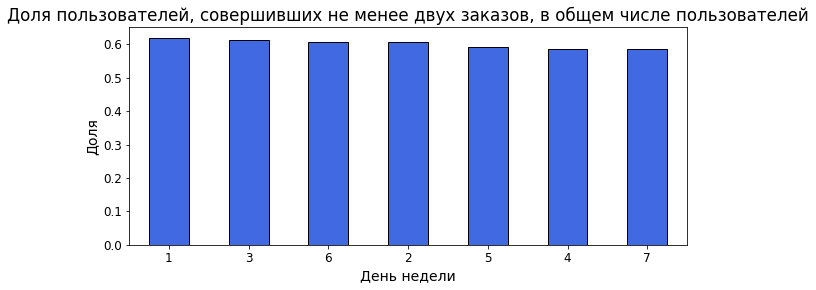

In [90]:
df_wd[('count', 'total_orders', 'share2')].sort_values(ascending=False).plot(
    kind='bar', 
    xlabel='День недели', 
    ylabel='Доля', 
    legend=False,
    rot=0, 
    title='Доля пользователей, совершивших не менее двух заказов, в общем числе пользователей', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue'],
    edgecolor='black'
    )
plt.show()

День недели не влияет на вероятность возврата пользователя

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [79]:
dff['btw_ord_group'] = pd.cut(dff['total_orders'], bins=[1,2,5,100], right=False, labels=['1 заказ','2-4 заказа','5+ заказов'])

/tmp/ipykernel_63/3647033815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['btw_ord_group'] = pd.cut(dff['total_orders'], bins=[1,2,5,100], right=False, labels=['1 заказ','2-4 заказа','5+ заказов'])


In [80]:
dff['btw_ord_group'].isna().sum()

0

In [81]:
# dff

In [82]:
pt_btw = pd.pivot_table(data=dff, index='btw_ord_group', values=['avg_days_between_orders'], aggfunc=['mean'])
df_btw = pd.DataFrame(pt_btw)
print('Рассчитайте среднее время между заказами для двух групп пользователей:')
df_btw

Рассчитайте среднее время между заказами для двух групп пользователей:


,mean
,avg_days_between_orders
btw_ord_group,
2-4 заказа,21.395944
5+ заказов,11.159396


In [83]:
dff['avg_days_between_orders'].max()

148.0

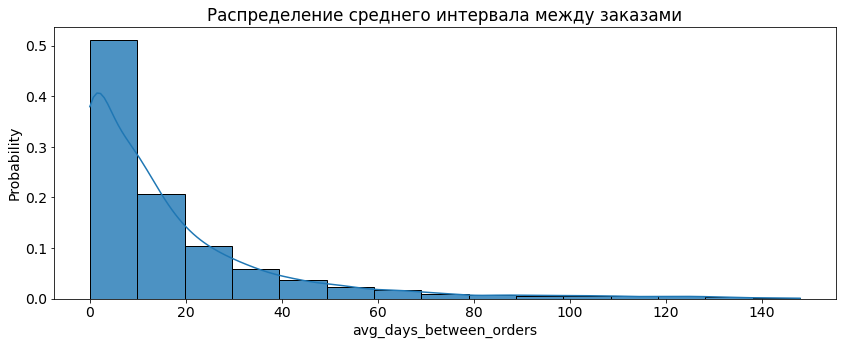

In [84]:
plt.figure(figsize=(14,5))
sns.histplot(data=dff, x='avg_days_between_orders', #hue='is_two', 
#              palette='muted',
             bins=15, kde=True, stat='probability', alpha=0.8)
plt.fontsize=14
plt.title('Распределение среднего интервала между заказами')
plt.show()

Вероятность того, что пользователь сделает повторный заказ снижается по мере увеличения интервала между заказами. Первые 10 дней - наиболее важные: вероятность возврата составляет 50%. К концу второй декады вероятность снижается до 20%.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [85]:
#содаем новый столбец для сегментации пользователей по total_orders
dff['total_orders_segment'] = pd.cut(dff['total_orders'], bins=[1,2,5,1000], right=False, labels=['A','B','C'])
print('Проверка пропусков в новом поле total_orders_segment:',dff['total_orders_segment'].isna().sum())
#Формируем два датафрейма с ограниченным перечнем полей для сравнения матриц корреляций
df_corr1 = dff[['total_orders','first_device','first_region','first_service','first_event_type','avg_revenue_rub',
                'avg_tickets_per_order','avg_days_between_orders','avg_ticket_price']]
df_corr2 = dff[['total_orders_segment','first_device','first_region','first_service','first_event_type','avg_revenue_rub',
                'avg_tickets_per_order','avg_days_between_orders','avg_ticket_price']]

int_cols1=['total_orders','avg_revenue_rub','avg_tickets_per_order','avg_days_between_orders','avg_ticket_price']
int_cols2=['avg_revenue_rub','avg_tickets_per_order','avg_days_between_orders','avg_ticket_price']
# bins_dict = {'total_orders': [1, 2, 5, 1000]}
corr_matrix1 = df_corr1.phik_matrix(interval_cols=int_cols1)#), bins=bins_dict)
corr_matrix2 = df_corr2.phik_matrix(interval_cols=int_cols2)#), bins=bins_dict)

/tmp/ipykernel_63/2468442076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['total_orders_segment'] = pd.cut(dff['total_orders'], bins=[1,2,5,1000], right=False, labels=['A','B','C'])


Проверка пропусков в новом поле total_orders_segment: 0


In [86]:
#corr_matrix1['total_orders']

In [87]:
#corr_matrix2['total_orders_segment']

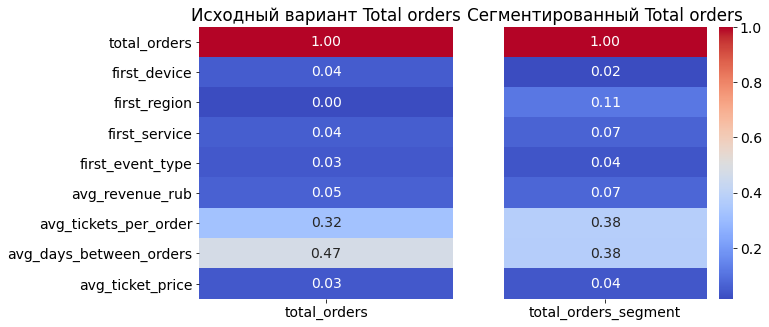

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Исходный вариант Total orders')
ax2.set_title('Сегментированный Total orders')
sns.heatmap(corr_matrix1[['total_orders']], ax=ax1, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
sns.heatmap(corr_matrix2[['total_orders_segment']], ax=ax2, cmap='coolwarm', annot=True, fmt='.2f', cbar=True, yticklabels=False)
plt.show()

Наибольшая связь с количеством заказов прослеживается у полей `"Среднее количество дней между заказами/avg_days_between_orders"` `"Среднее коичество билетов в заказе/avg_tickets_per_order"`. Оценка влияния этих факторов на вероятность возврата приведена в предыдущих пунктах.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

В соответствии с заданием с помощью SQL на основе данных таблиц БД Афиша был собран датасет с данными о заказах Афиши. Количество строк - ~291 тыс. Для конвертации курса казахской тенге в рубли использовался датасет (357 строк), содержащий выгрузку данных о динамике курса валюты по данным сайта ЦБ. Датасеты были объединены в один, выручка в тенге конвертирована в рубли. Из объединенного датасета были исключены строки со слишком высокими значениями выручки. Фильтрация по 99 перцинтилю позволила снизить искажения статистики и сделало более равномерным распредедение заказов по типам меропритий.

После предварительной обработки был сформирован новый датасет - профиль пользователя, содержащий агргированные данные по каждому пользователю. Новый датасет также был отфильтрован по 95% процентилю - для исключения из анализа пользователей с аномально большими заказами. 
Т.к. для части пользователей значения в поле `выручка/avg_revenue_rub` равнялись нулю, то для анализа показателей, связанных с выручкой соответствующие строки также были отфильтрованы. 

Для целей проведения аналитических расчетов в ходе выполнения проекта были созданы дополнительные поля, позволяющие категоризировать данные о пользователях в различных разрезах. Основое поле из дополнительных - `is_two`, содержащее указание на то, что пользователь совершал более одного заказа. Наличие в этом поле значения, равного единице, указаывает, что пользователь вернулся в сервис. 

*Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?*
    
    Обновленные данные после фильтрации по 95 процентилю:
- Общее число пользователей в выборке:  20864. Пользователи по числу заказов распределены неравномерно. С ростом числа заказов, количество пользователей экспоненциально снижается. 
- Средняя выручка с одного заказа:  581.11 руб.
- 60% пользователей вернулись. При этом 26% совершили 5 и более заказов.
- Пользователи чаще всего совершали 2 заказа, заказывая в среднем чуть менее 3 билетов. Медианное значение периода между заказами - 9 дней. При этом среднее - 17, т.к. в выборке есть пользователи с длительными периодом между заказами (несколько месяцев)

*Какие признаки первого заказа связаны с возвратом пользователей?*
    
    С возвратом пользователей связаны количество билетов в заказе, тип мероприятия, устройство, регион и оператор.
- Чаще всего возвращаются пользователи, посетившие концерты, театры и "другое" (вероятно, что эту категорию можно детализировать).
- Доля вернувшихся пользователей различается по регионам и операторам. 
- Пользователей, совершающих первый заказ с компьютера меньше, чем пользователей, совершающих заказы с мобильных устройств. Но возвращаются desktop-пользователи немного чаще. 

*Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?*
    
- С ростом средней выручки количество пользователей ожидаемо снижается. Но характер распределения разный у разных групп пользователей: большинство пользователей, сделавших только 1 заказ, приносят минимальную выручку, а далее с ростом выручки количество пользователей экспоненциально снижается. 
- В группе пользователей с 2 и более заказами наблюдается несколько иная динамика: минимальную среднюю выручку формирует небольшое количество пользователей. Далее, с ростом выручки количество пользователей увеличивается и, достигнув пика, начинается снижаться аналогично динамике первой группы. Вероятно пользователи, сделавшие несколько заказов, имеюют более высокие доходы, т.к. предпочитают посещение более дорогих мероприятий. 

 - Чаще всего возвращаются пользователи, покупающие 2-3 билета (72% вернувшихся). Второе место - у группы покупателей 3-5 билетов (54%), третье - 1-2 билета (51%), четвертое - 5+ билетов (19%) (вероятно группа сама по себе не многочисленна)

*Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?*

    День недели практически не влияет на удержание: доля вернувшихся пользователей колеблется около 60% +/-2%. 
    
    Интервалы между покупками влияют существенно: вероятность экспоненциально снижается с ростом инетрвала. Наиболее критичными являются первые 10 дней: вероятность возврата составляет 50%. За следующие 10 дней вероятность снижается до 20% и т.д.

*Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?*

    Корреляционный анализ показал, что наибольшую связь с `количеством заказов` имеют признаки `среднее количество дней между заказами` и `среднее количество билетов в заказе`.

**Рекомендации**

Общий принцип рекомендаций: Максимизировать эффект сильных качеств, улучшить показатели по отстающим направлениям.
    Необходимо работать над улучшением качества мероприятий, доступных на платформе. Интерфейс и логика работы приложения должна быть доработана таким образом, чтобы чаще вызывать желание пользователя сделать повторный заказ. При этом важно не допускать излишней навязчивости. 

1. Необходимо провести детальный анализ регионов с меньшей долей возвратов пользователей. Возможно, что качество мероприятий, доступных на платформе оставляет желать лучшего. 
2. Аналогичная рекомендация по операторам: должна быть разработана/улучшена система работы с операторами, введены специальные стимулирующие меры и т.д.
3. Анализ показал, что возвращаются пользователи, предположительно, с большим доходом (выше средняя вырычка - больше покупают более дорогие мероприятия). Вероятно, нужно дополнительно оценить необходимость концентрации на мероприятиях более высокой ценовой категории. Точнее, на - расширении перечня таких мероприятий. 
4. При выявлении соответствуюещей необходимости проводить модернизацию интерфейса приложения/сайта.
5. Т.к. количество дней сильно влияет на возврат пользователей, необходимо провести дополнительный анализ: нужно определить, что конкретно заставляет пользователя вернуться за следующим заказом в разрезе категорий мероприятий. По итогам провести соотвествующую доработку приложения и модернизировать алгоритмы отбора мероприятий. 
6. Между значимыми изменениями в работе проекта необходимо проводить A/B тестирование, внедрять изменения поэтапно для разных групп пользователей. 
7. 



### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

https://github.com/dimaxi1007/afisha